# Gaussian Process Regression

By Christopher J. Moore & Zoheyr Doctor

Prepared for two 1.5 hour practical sessions held at the "Workshop on Reduced Order Gravitational-Wave Modeling" at the Max Planck Institute for Gravitational Physics, Potsdam from $18^{\textrm{th}}-22^{\textrm{nd}}$ of June, $2018$.


In [35]:
import numpy as np
print ( "numpy version" , np.__version__ )

import scipy
from scipy import linalg as LA
print ( "scipy version" , scipy.__version__ )

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
print ( "matplotlib version" , matplotlib.__version__ )

# If you don't have emcee don't worry. You can either install it from...
# ... http://dfm.io/emcee/current/ or just forget about it, it is only used once below.
import emcee as mc
print ( "emcee version" , mc.__version__ )

# If you don't have corner don't worry. You can either install it from...
# ... http://corner.readthedocs.io/en/latest/install.html or just forget about it, it is only used once below.
import corner
print ( "corner version" , corner.__version__ )


numpy version 1.14.2
scipy version 0.19.1
matplotlib version 2.1.0
emcee version 2.2.1
corner version 2.0.1


# Useful References

[RW] - The textbook "Gaussian Processes for Machine Learning", by Carl Edward Rasmussen and Christopher K. I. Williams, MIT Press, 2006.

ZOHEYR, IS THERE ANYTHING ELSE YOU WANT TO ADD HERE?


# Table of Contents

ZOHEYR, THIS IS JUST A SUGGESTION FOR THE MOMENT, PLEASE FEEL FREE TO MODIFY THE STRUCTURE.

1 Introduction

2 What is a Gaussian Processes?
 - 2.1 Gaussian, or "Normal", Random Variables
 - 2.2 Gaussian Processes
 - 2.3 Some Examples of Gaussian Processes
 - - 2.3.1 Straight Line
 - - 2.3.2 Brownian Motion
 - - 2.3.2 Squared Exponential

3 The Covariance Function
 - 3.1 Some General Terminology
 - 3.2 Bochner's Theorem
 - 3.3 Some Commonly Used Covariance Functions
 - - 3.3.1 SE
 - - 3.3.2 Matern
 - - 3.3.3 Wendland Polynomials
 - 3.4 Building New Covariance Functions From Old Ones
 - 3.5 Mean Square Continuity and Differentiability

4 Using Gaussian Processes for Regression
 - 4.1 Example using Squared-Exponential Covariance Function
 - - 4.1.1 Conditioning
 - 4.2 Choosing the Kernel and Hyperparameters

5 Gaussian Process Regression: A More Sophisticated Gravitational Wave Example

6 Conclusions


# 1 Introduction

WE NEED TO WRTIE AN INTRODUCTION HERE

This Jupyter notebook has been prepared to run with python 3, and generally requires only standard libraries to run: numpy (tested with version 1.14.2), scipy (tested with version 0.19.1) and matplotlib (tested with version 2.1.0). In a single example the MCMC library emcee and (tested with version 2.2.1) plotting library corner (tested with version 2.0.1) is also used, which can be installed from http://dfm.io/emcee/current/ and http://corner.readthedocs.io/en/latest/install.html respectively.


# 2 What is a Gaussian Process?

A Gaussian Process may be regarded as an infinite dimensional generalisation of the more familiar concept of a finite dimensional Gaussian random variable. Therefore we begin by recapping finite dimensional Gaussian (or "normal") random variables.


## 2.1 Gaussian, or "Normal", Random Variables

A continuous random variable $z\in\mathbb{R}$ is said to be Gaussian distributed if its probability density function (PDF) is given by

$$ P(z)\,\textrm{d}z = \frac{\exp\left(\frac{-1}{2}\left(\frac{z-\mu}{\sigma}\right)^{2}\right)}{\sqrt{2\pi\sigma^{2}}} \,\textrm{d}z \,, \hspace{1cm}\textrm{(2.1)} $$

where $\mu$ is the "mean" and $\sigma^{2}$ is the "variance";

$$\textrm{E}\left[ z \right] \equiv \int\textrm{d}z\,P(z)\,z = \mu \,, $$
$$\textrm{E}\left[ \left(z-\mu\right)^{2} \right] \equiv \int\textrm{d}z\,P(z)\left(z-\mu\right)^{2} = \sigma^{2} \,.$$

The variance must always be non-negative; i.e. $\sigma^{2}\geq 0$.
Eq.(2.1) is clumbersome to write, so the following shorthand is usually adopted,

$$ z \sim \mathcal{N}(\mu,\sigma)\,. $$

$$\phantom{.}$$

A continuous random $N$-vector $\mathbf{z}^{\textrm{T}}=(z_{1},z_{2},\ldots,z_{N})\in\mathbb{R}^{N}$ is said to be Gaussian distributed if its probability density function (PDF) is given by

$$ P(\mathbf{z})\,\textrm{d}\mathbf{z} = \frac{\exp\left(\frac{-1}{2}(\mathbf{z}-\mathbf{\mu})^{\textrm{T}}\cdot\mathbf{K}^{-1}\cdot (\mathbf{z}-\mathbf{\mu})\right)}{\sqrt{(2\pi)^{N}\left|\mathbf{K}\right|}} \,\textrm{d}\mathbf{z} \,, \hspace{1cm}\textrm{(2.2)} $$

where $\mathbf{\mu}$ is the "mean" $N$-vector and $\mathbf{K}$ is the $N\times N$ "covariance" matrix;

$$\textrm{E}\left[ \mathbf{z} \right] \equiv \int\textrm{d}\mathbf{z}\,P(\mathbf{z})\mathbf{z} = \mathbf{\mu} \,, $$
$$\textrm{E}\left[ \left(\mathbf{z}-\mathbf{\mu}\right)\left(\mathbf{z}-\mathbf{\mu}\right)^{\textrm{T}} \right] \equiv \int\textrm{d}\mathbf{z}\,P(\mathbf{z})\left(\mathbf{z}-\mathbf{\mu}\right)\left(\mathbf{z}-\mathbf{\mu}\right)^{\textrm{T}} = \mathbf{K} \,. $$

The covariance matrix must always be symmetric (i.e. $\mathbf{K}=\mathbf{K}^{\textrm{T}}$) and positive semi-definite.

$\textbf{Definition: }$ A real $N\times N$ matrix $\mathbf{K}$ is positive semi-definite if $\mathbf{u}^{\textrm{T}}\cdot\mathbf{K}\cdot\mathbf{u}\geq 0$ for any $N$-vector $\mathbf{u}\in\mathbb{R}^{N}$.
If $\mathbf{u}^{\textrm{T}}\cdot\mathbf{K}\cdot\mathbf{u} = 0 \Rightarrow \mathbf{u}=\mathbf{0}$ then $\mathbf{K}$ is said to be strictly positive definite.

$\textbf{Exercise: }$ Show that a symmetric matrix is positive semi-definite if and only if all of its eigenvalues are non-negative.

Eq.(2.2) is clumbersome to write, so the following shorthand is usually adopted,

$$ \mathbf{z} \sim \mathcal{N}(\mathbf{\mu},\mathbf{K})\,. $$

$$\phantom{.}$$

We will assume the reader is familiar with most of the properties of multivariate Gaussian distributions. However, we will point out that a Gaussian distribution is fully specified by just the mean $\mathbf{\mu}$ and the pairwise covariance matrix $\mathbf{K}$ (all the higher order moments, e.g. $\textrm{E}\big[z_{1}\times z_{2} \times z_{3}\big]$, may be expressed in terms of just $\mathbf{\mu}$ and $\mathbf{K}$). We also poinrt our the "affine" property of Gaussian random variables which will be relevant in what follows; if $\mathbf{z} \sim \mathcal{N}(\mathbf{\mu},\mathbf{K})$ then for any $M$-vector $\mathbf{a}$ and $M\times N$ matrix $b$, the vector $\mathbf{y}=\mathbf{a}+\mathbf{b}\cdot\mathbf{z}$ is also a Gaussian random variable, $\mathbf{y}\sim\mathcal{N}(\mathbf{a}+\mathbf{b}\cdot\mathbf{\mu},\mathbf{b}\cdot\mathbf{K}\cdot\mathbf{b}^{\textrm{T}})$. In particular, this implies that any subset of the components of $\mathbf{z}$ is a Gaussian random variable and the covariance matrix is given by the relevant subset of the components of $\mathbf{K}$.

$$\phantom{.}$$

It is easy to verify that the random $N$-vector $\mathbf{z}'=\mathbf{z}-\mathbf{\mu}$ is distributed as $\mathbf{z}' \sim \mathcal{N}(\mathbf{0},\mathbf{\Sigma})$. For this reason we will usually (without loss of generality) choose to work with zero-mean Gaussian random variables.

$$\phantom{.}$$

Gaussian random variables are well suppported in any sensible programming language; e.g. python$\ldots$


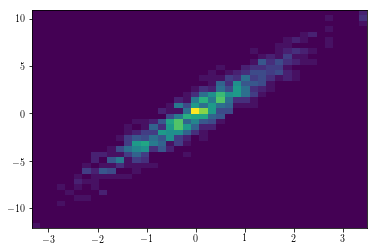

In [2]:
# A mean 2-vector and a 2 by 2 covariance matrix
mu = np.array ( [ 0 , 0 ] )
K = np.array ( [ [ 1 , 3 ] , [ 3 , 10 ] ] )

# Draw 1000 realisations of the Gaussian random variable z~N(mu,K)
dist = np.array ( [ np.random.multivariate_normal ( mu , K ) for i in range ( 1000 ) ] )

# Plot the distribution of z
plt.hist2d ( dist[:,0] , dist[:,1] , bins=40 )
plt.show ( )


## 2.2 Gaussian Processes

Instead of distributions over a finite number of random variables (i.e. a random vector) we now wish to consider distributions smooth random functions. For some set $\mathcal{S}$ we will consider real valued functions $\,f:\mathcal{S}\rightarrow\mathbb{R}$. The random variables will be the values of the function evaluated at particular inputs; i.e. $f(x)$ for $x\in\mathcal{S}$.

We will use the following definition of a Gaussian process (GP).

$\textbf{Definition }$ For any set $\mathcal{S}$, a GP on $\mathcal{S}$ is a collection of random variables $\{{f(x):x\in \mathcal{S}\}}$ such that for any finite ${n\in\mathbb{N}}$, and any ${x_{1},x_{2},\ldots,x_{n}\in\mathcal{S}}$, the vector ${\left(f(x_{1}),f(x_{2}),\ldots,f(x_{n})\right)\in\mathbb{R}^{n}}$ is distributed as a multivariate Gaussian.

Notice that in this definition the set $\mathcal{S}$ can be either finite and infinite dimensional. However, the finite case is of little interest as this definition simply reduces to the familiar multivariate Gaussian distribution.

$$\phantom{.}$$

$\textbf{An Example of a GP: }$ For this audience perhaps the most familiar example of a Gaussian process is the noise in a gravitational wave interferometer. 
The noise is a real valued function of time. 
The noise is usually assumed to be stationary and Gaussian, meaning that in the frequency domain $\textrm{E}\left[ {\widetilde{n}} (f) {\widetilde{n}} (f')^{*}\right]=\frac{1}{2}S_{n}(f)\delta(f-f')$. 
From the definition of the Fourier transform, it follows that in the time domain $\textrm{E}\left[n(t)n(t')\right]=\int_{0}^{\infty}S_{n}(f)\cos\left(2\pi f(t-t')\right) \equiv \kappa(t-t')$. 
We are using theA Fourier transform conventions of [arXiv:1408.0740]. The function $S_{n}(f)$ is the detector's one-sided noise power spectral density (usually given in units of $\textrm{Hz}^{-1}$).
Comparing with our above definition we see that in this case $\mathcal{S}=\mathbb{R}$, $x=t$, and $z(x)=n(t)$. 
The vector of noise values at any finite number of times, $\mathbf{n}\equiv\left(n(t_{1}),n(t_{2}),\ldots,n(t_{N})\right)$, is distributed as $\mathbf{n}\sim\mathcal{N}(\mathbf{0},\mathbf{K})$, where

$$\mathbf{K} = \begin{pmatrix} \kappa(t_{1}-t_{1}) & \kappa(t_{1}-t_{2}) & \ldots & \kappa(t_{1}-t_{N}) \\ \kappa(t_{2}-t_{1}) & \kappa(t_{2}-t_{2}) & \ldots & \kappa(t_{2}-t_{N}) \\ \vdots & \vdots & \ddots & \vdots \\ \kappa(t_{N}-t_{1}) & \kappa(t_{N}-t_{2}) & \ldots & \kappa(t_{N}-t_{N})  \end{pmatrix}\,.$$

$$\phantom{.}$$

We may easily construct new GPs with any properties we desire by specifying the desired mean ($\mu(x)=\textrm{E}\big[f(x)\big]$) and pairwise covariance ($k(x,x')=\textrm{E}\Big[\big(f(x)-\mu(x)\big)\big(f(x')-\mu(x')\big)\Big]$). We are free to choose any mean function, $\mu:\mathcal{S}\rightarrow\mathbb{R}$; just as with Gaussian distributions, we will usually work with zero-mean GPs, $\mu(x)=0$ for all $x\in\mathcal{S}$. We are also free to choose any "covariance function", $k:\mathcal{S}\times\mathcal{S}\rightarrow\mathbb{R}$, subject to some constraints. Extending the notation in Eqs. 1.1 and 1.2, if a function $f(x)$ is drawn from a GP with mean function $\mu(x)$ and covariance function $k(x,x')$ then we write

$$f(x) \sim \mathcal{GP}( \, \mu(x) \, , \, k(x,x') \, ) \hspace{3cm} \textrm{(2.3)}$$

Following out definition of a GP, we may consider any finite set of points $\mathbf{x}_{*}^{\textrm{T}} = (x_{1},x_{2},\ldots,x_{N})$ and the $N$-vector $\mathbf{f}_{*}^{\textrm{T}}=\left(f(x_{1}),f(x_{2}),\ldots,f(x_{N})\right)$ must distributed as $\mathbf{f}_{*} \sim \mathcal{N}( \mathbf{M} , \mathbf{K} )$, where

$$ \begin{align} 
&\mathbf{M}^{\textrm{T}} = \big( \, \mu(x_{1}) \, , \, \mu(x_{2}) \, , \ldots , \, \mu(x_{N}) \, \big) \,, \hspace{2cm} &\textrm{(2.4)} \\
\textrm{and } \; &\mathbf{K} =  \begin{pmatrix} k(x_{1},x_{1}) & k(x_{1},x_{2}) & \ldots & k(x_{1},x_{N}) \\ k(x_{2},x_{1}) & k(x_{2},x_{2}) & \ldots & k(x_{2},x_{N}) \\ \vdots & \vdots & \ddots & \vdots \\ k(x_{N},x_{1}) & k(x_{N},x_{2}) & \ldots & k(x_{N},x_{N})  \end{pmatrix} \,. \hspace{2cm} &\textrm{(2.5)}
\end{align} $$

If equation (2.3) is to correctly describe a good GP, then the matrix $\mathbf{K}$ formed in equation (2.5) must always be a valid be symmetric positive semi-definite covariance matrix. Therefore the covariance function $k(x,x')$ must be a symmetric function (i.e. $k(x,x')=k(x',x)$) and a "positive semi-definite function".

$\textbf{Definition: }$ A covariance function $k:\mathcal{S}\times\mathcal{S}\rightarrow\mathbb{R}$ is positive semi-definite if the $N\times N$ matrix \textrm{$K_{ij}=k(x_{i},x_{j})$ is positive semi-definite for all sets of points $x_{1},x_{2},\ldots,x_{n}\in\mathcal{S}$ for any $N\in\mathbb{N}$.

$$\phantom{.}$$

Notice that in equation (2.3) we have specified the pairwise covariances between any subset of the random variables. The affine property of Gaussian distributions ensures that this will never lead to contradiction. If $(f(x_1),f(x_2))\sim\mathcal{N}\big(\left[0,0\right],\left[\left[k(x_1,x_1),k(x_1,x_2)\right],\left[k(x_2,x_1),k(x_2,x_2)\right]\right]\big)$ then $f(x_1)\sim\mathcal{N}\big(0,k(x_1,x_1)\big)$, as required.


## 2.3 Some Examples of Gaussian Processes

### 2.3.1 Straight Line

Consider the Gaussian process on the real line ($\mathcal{S}=\mathbb{R}$) with $\mu(x) = 0$ and $k_{\textrm{line}}(x,x')=xx'$.

To show that this is indeed a valid GP we need to show that $k_{\textrm{line}}(x,x')$ is a symmetric positive semi-definite covariance function. It is obviously symmetric, but the positive definite property requires a proof. 
This can be proved by considering the eigenvalues of the covariance matrix formed by acting $k$ on any finite set of points $\mathbf{x}=(x_{1},x_{2},\ldots,x_{n})$; the covariance matrix is $\mathbf{K}=\mathbf{x}\otimes\mathbf{x}^{\textrm{T}}$. 
This matrix has one eigenvalue $\lambda=\left|\mathbf{x}\right|^{2} \geq 0$ corresponding to the eigenvector $\mathbf{x}$, and all of the remaining eigenvectors vanish.
Because all of the eigenvalues are non-negative for any choice of points $\mathbf{x}$, and for any $n\in\mathbb{N}$, the covariance function $k_{\textrm{line}}(x,x')$ is positive semi-definite.

We will now plot a realisation of this GP. The code in the following cell defines $\mu(x)$, $k_{\textrm{line}}(x,x')$, and the vector $\mathbf{x}_{*}$ which is chosen to be a densely sampled vector of points in the range $0\leq x < 10$. Try running the following cell several times to get a sense of the behaviour of this GP.


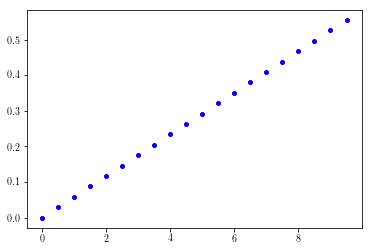

In [3]:
# Straight Line

# The mean function of the GP
def mu ( x ):
    return 0

# The covariance function of the GP
def k_line ( x , y ):
    return x * y

# The sampling points
x_star = np.arange ( 0 , 10 , 0.5 )

# The mean N-vector - formed from the mean function, mu
M = np.array ( [ mu(x) for x in x_star ] )

# The N by N covariance matrix - formed from the covariance function, k.
K = np.array( [ [ k_line(x,y) for x in x_star ] for y in x_star ] )

# A random realisation of the function values - drawn from the multivariate Gaussian distribution ~ N(M,K)
f_star = np.random.multivariate_normal ( M , K )

# Plot a realisation of the GP
plt.plot ( x_star , f_star , 'bo' , markersize=4 )
plt.show ( )

$\textbf{Exercise:}$ If you were to run the above cell many times and record the gradients of lines obtained, what would distribution would the gradients follow? 


### 2.3.2 Brownian Motion

Consider the Gaussian process on the positive real line ($\mathcal{S}=\mathbb{R}_{+}$) with $\mu(x) = 0$ and $k_{\textrm{Brownian}}(x,x')=\textrm{min}(x,x')$.

To show that this is a valid GP we need to show that $k_{\textrm{Brownian}}(x,x')$ is a symmetric positive semi-definite covariance function. As was the case in the previous example 2.3.1 the symmetry property is obvious, but the positive semi-definite property requires proof. 

$\textbf{Exercise:}$ Show that $k_{\textrm{Brownian}}(x,x')$ is a positive semi-definite function. 

$\textbf{Hint: }$ Let $H(t;x)=\begin{cases}1\quad\textrm{if }t\leq x\\0\quad\textrm{else}\end{cases}\,,$ and write the $\textrm{min}$ function as $\textrm{min}(x_{i},x_{j})=\int_{0}^{\infty}\textrm{d}t\;H(t;x_{i})H(t;x_{j})\,.$ 

We will now plot a realisation of this GP. The code in the following cell defines $\mu(x)$, $k_{\textrm{line}}(x,x')$, and the vector $\mathbf{x}_{*}$ which is chosen to be a densely sampled vector of points in the range $0\leq x < 10$. Try running the following cell several times to get a sense of the behaviour of this GP.


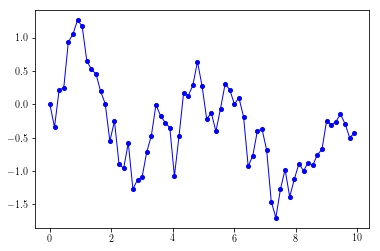

In [4]:
# Brownian Motion

# The mean function of the GP
def mu ( x ):
    return 0

# The covariance function of the GP
def k_Brownian ( x , y ):
    return min ( x , y )

# The sampling points
x_star = np.arange ( 0 , 10 , 0.15 )

# The mean N-vector - formed from the mean function, mu
M = np.array ( [ mu(x) for x in x_star ] )

# The N by N covariance matrix - formed from the covariance function, k.
K = np.array( [ [ k_Brownian(x,y) for x in x_star ] for y in x_star ] )

# A random realisation of the function values - drawn from the multivariate Gaussian distribution ~ N(M,K)
f_star = np.random.multivariate_normal ( M , K )

# Plot a realisation of the GP
plt.plot ( x_star , f_star , linewidth=1 , marker='o' , markersize=4 , color='b' )
plt.show ( )

### 2.3.3 Squared Exponential

Consider the Gaussian process with $\mu(x) = 0$ and $k_{\textrm{SE}}(x,x')=\exp\left(-\frac{1}{2}(x-x')^{2}\right)$. This is an example of a "squared exponential" covariance function 

The function $k_{\textrm{SE}}(x,x')$ is also symmetric positive semi-definite; this will be discussed further in section 3.

We will now plot a realisation of this GP. The code in the following cell defines $\mu(x)$, $k_{\textrm{line}}(x,x')$, and the vector $\mathbf{x}_{*}$ which is chosen to be a densely sampled vector of points in the range $0\leq x < 10$. Try running the following cell several times to get a sense of the behaviour of this GP.


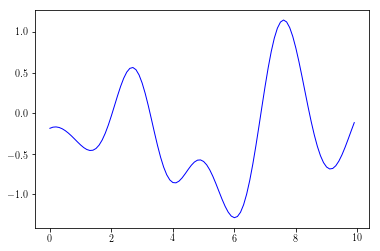

In [5]:
# Squared exponential

# The mean function of the GP
def mu ( x ):
    return 0

# The covariance function of the GP - this is an example of a "squared exponential" covariance function, see Sec.?
def k_SE ( x , y ):
    return np.exp ( -0.5 * (x-y) * (x-y) )

# The sampling points
x_star = np.arange ( 0 , 10 , 0.1 )

# The mean N-vector - formed from the mean function, mu
M = np.array ( [ mu(x) for x in x_star ] )

# The N by N covariance matrix - formed from the covariance function, k.
K = np.array( [ [ k_SE(x,y) for x in x_star ] for y in x_star ] )

# A random realisation of the function values - drawn from the multivariate Gaussian distribution ~ N(M,K)
f_star = np.random.multivariate_normal ( M , K )

# Plot a realisation of the GP
plt.plot ( x_star , f_star , linewidth=1 , color='b' )
plt.show ( )


$\textbf{Exercise:}$ The above cell generates random realisations of a squared exponential covariance function. Try modifying the covariance function to $k_{\textrm{SE}}(x,x')=\sigma_{f}^{2}\exp\left(\frac{-1}{2}\frac{(x-x')^{2}}{\ell^{2}}\right)$ and experiment with different choices of $\sigma_{f}$ and $\ell$. Explore how the these two "hyperparameters" (see Sec.3) control the properties of the GP. (You can also experiment with using a non-zero mean function, $\mu(x)$.) Also try experimenting with using $k_{\textrm{?}}(x,x')=\exp\left(\frac{-1}{2}(x-x')^{3}\right)$. Why doesn't this work?


Notice that the examples $2.3.1$ and $2.3.1$ had a prefered value on the x axis at $x=0$. The squared-exponential does not have any such prefered point, in fact it is translation invariant; $k(x,x')=k(x+\Delta,x'+\Delta)$. A covariance function with this property, $k(x,x')=k(x-x')$, is called "stationary".

Notice also that in the example 2.3.3 we have choosen to stop drawing the curve with points and instead use a smooth line. Of course, whenever any practical computation on GPs is performed it is always with a finite number of points, so a list plot is more honest. However, the sampling of the points $\mathbf{x}_{*}$ is arbitrary and in the example $2.3.3$ the choice was designed to show the smooth behaviour of the underlying GP, so perhaps the line plot is more appropriate.


# 3 The Covariance Function

In section 2 we saw that a GP can be specified by a symmetric positive definite covariance function, $k(x,x')$. Covariance functions are also sometimes known as "kernels". We also saw through several examples that this covariance function governs the properties of the GP. In this section we will introduce several covariance functions which are commonly used for regression in a more systematic way and also explore more formally how the covariance function governs the "smoothness" of the GP.


## 3.1 Some General Terminology

In this section we will consider covariance functions of GPs over $\mathcal{S}=\mathbb{R}^{N}$. In what follows $x,x'\in\mathbb{R}^{N}$, angled brackets $\left<x|x'\right>$ denotes the standard Euclidean inner product between the $N$-vectors $x$ and $x'$, and $|x|=\sqrt{\left<x|x\right>}$ denotes the standard Euclidean norm of $x$.

$\textbf{Definition: }$ A covariance function is said to be "stationary" if it depends only on the difference of the inputs; i.e. $k(x,x')=k(\tau)$, where $\tau=x-x'$. A stationary covariance function is invariant under translations; i.e. $k(x,x')=k(x+\Delta,x'+\Delta)$.

$\textbf{Definition: }$ A stationary covariance function is said to be "isotropic" if it is only a function of the Euclidean distance between the inputs; $k(x,x')=k(r)$, where $r=\left|x-x'\right|$. An isotropic covariance function is invariant under rotations as well as translations.



## 3.2 Bochner's Theorem

In section 2 we encoutered several examples of covariance functions and in each case we had to prove that they were symmetric and positive semi-definite. The proof was different in each case, and in general there is no easy way to establish whether a particular function is positive semi-definite. (Although, it is usually easy to prove that a particular function is NOT positive semi-definite by simply evaluating the covariance matrix formed from a particular set of points and showing that it has at least one negative eigenvalue.)

$\textbf{Exercise: }$ Show that the function $k(x,x')=\begin{cases} \exp(-(x-x')^{2}) &\;\textrm{if }|x-x'|<1 \\ 0 &\;\textrm{else} \end{cases}$ is NOT positive semi-definite.

$$\phantom{.}$$

Fortunately there is a theorem which allows us to easy establish whether a STATIONARY function, $k(r)$ is positive definite.

$\textbf{Bochner's Theorem: }$ A complex-valued function $k$ on $\mathbb{R}^{N}$ is the covariance function of a stationary mean square continuous complex-valued GP on $\mathbb{R}^{N}$ if and only if it can be written as the following integral using a positive finite measure $M(x)$ on $\mathbb{R}^{N}$;
$$k(\tau) = \int_{\mathbb{R}^{N}}\textrm{d}M(x) \; \exp\big(2\pi i \left<x|\tau\right> \big) \,. $$

$$k(\tau) = \int_{\mathbb{R}^{N}}\textrm{d}x \; S(x) \exp\big(2\pi i \left<x|\tau\right> \big) \,. $$

The density of the measure, $M(x)$, is known as the "Power spectrum" of the covariance funtion.

In section 2 we introduced the squared exponential covariance function. We may now use Bochner's theorem to prove that this function is positive definite. The Fourier transform of the squared exponential function is another squared exponential, which is always positive and has a finite area. Therefore, by Bochner's theorem the function $k_{SE}$ is positive definite. 

$\textbf{Exercise: }$ Show that the function $k(x,x')=\begin{cases} \exp(-(x-x')^{2}) &\;\textrm{if }|x-x'|<1 \\ 0 &\;\textrm{else} \end{cases}$ is NOT positive semi-definite, this time using Bochner's theorem.

## 3.3 Some Commonly Used Covariance Functions

In this section we will list some covariance functions that have been widely used for regression.

All these covariance functions will be on $\mathcal{S}=\mathbb{R}^{N}$.

### 3.3.1 Squared Exponential

Probably the most widely used covariance function

The Gaussian process regression depends crucially on the kernel function, which encodes the covariance between values of our function of interest. The kernel function is used directly to compute values of the $K$ submatrices presented above.  Let's start with the most basic kernel, the squared exponential, which has the form:

$$k(x,x') = \exp\left(-\frac{1}{2}\frac{||x-x'||^2}{l^2}\right)$$

We can write a more flexible version too (Einstein summation convention used):

$$k(x,x') = \exp\left(-\frac{1}{2}g_{ab}x_ax_b\right)$$

$l$ or the components of $g_{ab}$ are chosen by the user or can be optimized for.  Below, we've defined a squared exponential kernel method that will compute the $K$ matrix with $k({\bf x},{\bf x_*})$ between points $\texttt{X1}$ and $\texttt{X2}$.

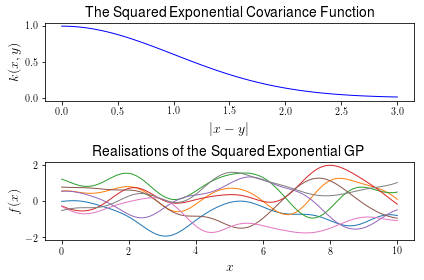

In [9]:
def squared_exponential_kernel(X1,X2,scale=1.0,metric=None):
    """
    Computes the square exponential kernel.
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale=(1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            K[i,j] = np.exp(-0.5*dist(X1[i,:],X2[j,:])**2)
    return K


# Plot the covariance function and some random realisations of the process

fig = plt.figure (  )
ax1 = fig.add_subplot ( 2 , 1 , 1 )
ax2 = fig.add_subplot ( 2 , 1 , 2 )

x_star = np.linspace ( 0 , 3 , 100 ).reshape(-1,1)
ax1.plot ( x_star.flatten() , squared_exponential_kernel ( x_star , x_star )[0] , linewidth=1 , color='b' ) 
ax1.set_title ( r'The Squared Exponential Covariance Function' , fontsize=14 )    
ax1.set_xlabel ( r'$|x-y|$' , fontsize=14 )
ax1.set_ylabel ( r'$k(x,y)$' , fontsize=14 )

x_star = np.linspace ( 0 , 10 , 100 ).reshape(-1,1)
K = squared_exponential_kernel ( x_star , x_star )
for i in range(8):
    f_star = np.random.multivariate_normal ( np.zeros(len(x_star)) , K )
    ax2.plot ( x_star , f_star , linewidth=1 )
    
ax2.set_title ( r'Realisations of the Squared Exponential GP' , fontsize=14 )    
ax2.set_xlabel ( r'$x$' , fontsize=14 )
ax2.set_ylabel ( r'$f(x)$' , fontsize=14 )

plt.tight_layout()
plt.show ( )


### 3.3.2 Matern

WE SHOULD WRITE SOMETHING SIMILAR TO SECTION 3.3.1 HERE, BUT FOR THE MATERN FUNCTION.

### 3.3.3 Wendland Polynomials

WE SHOULD WRITE SOMETHING SIMILAR TO SECTION 3.3.1 HERE, BUT FOR THE WENDLAND POLYNOMIALS.

## 3.4 Building New Covariance Functions From Old Ones

Given one or more seed covariance functions there are several ways to construct new covariance functions. 

This will be useful when performing regression; for example, when interpolating a smooth function plus some amount of additive noise.

$\textbf{Summation: }$ For any two covariance functions, $k_{1}(x,x')$ and $k_{2}(x,x')$, the sum $k(x,x')=k_{1}(x,x')+k_{2}(x,x')$ is a new covariance function.

$\textbf{Product: }$ For any two covariance functions, $k_{1}(x,x')$ and $k_{2}(x,x')$, the product $k(x,x')=k_{1}(x,x')\times k_{2}(x,x')$ is a new covariance function.

$\textbf{Warping: }$ 

$\textbf{Renormalisation: }$ For any covariance function $k(x,x')$ and any function $\alpha(x)$, the function $\alpha(x)k(x,x')\alpha(x')$ is a new covariance function.

$\textbf{Exercise: }$ Prove all of the above statements.

$\textbf{Exercise: }$ Use the warping property to prove that the period covariance function is indeed positive definite.

## 3.5 Mean Square Continuity and Differentiability

CHRIS WILL WRITE THIS SECTION.

R. J. Adler, The Geometry of Random Fields, Wiley Series in Probability and Mathematical Statistics (Wiley, Chichester, 1981)

# 4 Gaussian Processes Regression

In the examples presented thus far, samples have been generated from some covariance matrix that describes the full joint distribution on function values.  In Gaussian process regression, one is interested in _conditional_ distributions of function values.  We seek to infer possible function values conditioned on a few known values of the function. We can write the joint probability distribution of function values ${\bf f}_*$ at points $X_*$ and ${\bf f}$ at points $X$ as:

$$p([{\bf f}, {\bf f}_*]) = \frac{1}{(2\pi)^{n/2}|K|^{1/2}}\exp\left(-\frac{1}{2}[{\bf f}, {\bf f}_*]^\top K^{-1}[{\bf f}, {\bf f}_*]\right) \hspace{2cm} \textrm{(4.1)}$$

Let's define:
$$\Gamma = K^{-1} = 
\begin{pmatrix} 
\Gamma_{XX} & \Gamma_{XX_*}  \\ 
\Gamma_{XX_*} & \Gamma_{X_*X_*}  \\
\end{pmatrix}, 
K=
\begin{pmatrix} 
K_{XX} & K_{XX_*}  \\ 
K_{X_*X} & K_{X_*X_*}  \\
\end{pmatrix}$$

If we condition on known ${\bf f}$, then all terms with only ${\bf f}$'s become constants and can be ignored:

$$
\begin{align}
p({\bf f}_*|{\bf f}) & \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\Gamma_{X_*X_*}{\bf f_*} - {\bf f}^\top\Gamma_{XX_*}{\bf f_*}\right) \hspace{2cm} \textrm{(4.2)}\\
& 
\end{align}
$$ 

The relations between the submatrices of $\Gamma$ and $K$ are:

$$\Gamma_{XX_*} = -K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$
$$\Gamma_{X_*X_*} = \left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$

The $K$ matrices are the covariances between test and/or input values of $f(x)$.  Substituting those into Equation (4.2) yields:

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}{\bf f_*} - {\bf f}^\top\left(-K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}\right){\bf f_*}\right)$$

We can complete the square by adding this term in the exponential:

$$-\frac{1}{2}{\bf f}^\top\left(K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}K_{X_*X}K_{XX}^{-1}\right){\bf f}$$

Notice that this term is independent of ${\bf f}_*$, so adding it in the exponential only affects the normalization.  After completing the square, we get 

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})\right)$$

We see that this is now a multivariate Gaussian with mean $K_{X_*X}K_{XX}^{-1}{\bf f}$ and covariance $K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This result is the workhorse of Gaussian process regression, and we summarize it here:

$$ p({\bf f}_*|{\bf f}) \sim \mathcal{N}\left(K_{X_*X}K_{XX}^{-1}{\bf f}, \hspace{0.2cm} K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right) \hspace{2cm} \textrm{(4.3)}$$

Let's take a second to digest this equation.  First, we can see that the mean values of ${\bf f}_*$ are generated by a linear transformation of the input values ${\bf f}$. Second, the variance of the conditional distribution is independent of ${\bf f}$ -- it only depends on the $K$ matrices, which are constructed only from $X$, $X_*$ and the kernel.  Therefore, local behavior of the values of ${\bf f}$ does not affect the predicted conditional variances. Also note that the first term of the conditional covariance is simply the prior covariance $K_{X_*X_*}$ and from it is subtracted $K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This second term is large when values of $K_{X_*X}$ and $K_{XX_*}$ are large and/or $K_{XX}$ values are small. Thus if a kernel such as the squared-exponential is used, where the covariance falls off with the distance between parameter values, ${\bf f}_*$ will be distributed like the prior if $X_*$ are "far away" from $X$ since the second term will go to zero.   


## 4.1 Example using Squared-Exponential Covariance Function

Now that we have Equation 4.3, let's perform some regression!  To do this, we'll need to choose a covariance function and we'll require a bit more machinery in terms of practically performing the matrix operations required on a computer. 

The Gaussian process regression depends crucially on the kernel function, which encodes the covariance between values of our function of interest. The kernel function is used directly to compute values of the $K$ submatrices presented above.  Let's start with the most basic kernel, the squared exponential. Below, we've defined a squared exponential kernel method that will compute the $K$ matrix with $k({\bf x},{\bf x_*})$ between points $\texttt{X1}$ and $\texttt{X2}$.

In the cell below, plot samples from the prior.  Try changing the scale and nugget values and see what happens.  The "nugget" is just a set of values added to the diagonal of the covariance matrix to ensure numerical stability and to account for variance in the training data.  

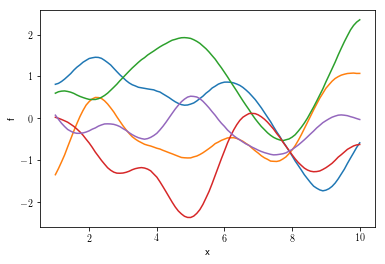

In [28]:
X = np.linspace(1,10,100).reshape(-1,1)
length_scale = 1.0
cov_scale = 1.0
K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
nugget_val = 1e-5
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
for i in range(5):
    f = np.random.multivariate_normal(np.zeros(K.shape[0]), K+nugget)
    plt.plot(X,f)
plt.xlabel('x')
plt.ylabel('f')
plt.show()

### 4.1.1 Conditioning

Now let's condition the GP we created with our squared-exponential kernel.  To do this, we need to take the inverse of $K_{XX}$.  We will effectively do this via the Cholesky decomposition, which decomposes a matrix $K$ as $K=LL^\top$, where $L$ and $L^\top$ are lower and upper triangular matrices, respectively. Rather than directly find the inverse of $K$, we can solve for the vector ${\bf x}$ which fulfills the equation:
$$ {\bf y} = K{\bf x} = LL^\top{\bf x}$$
We write the solution as ${\bf x} = K\setminus {\bf y}$.  Substituting in the triangular matrices, we have ${\bf x} = L^\top\setminus (L \setminus {\bf y})$.  To solve for ${\bf b} = L \setminus {\bf y}$, use forward substitution and for $x = L^\top\setminus {\bf b}$ use backward substitution. With this inversion scheme in hand, we can write the numerical procedure algorithmically as (following Rasmussen and Williams Algorithm 2.1):

1. $L := {\rm Cholesky}(K)$
2. ${\bf \alpha} := L^\top \setminus (L \setminus {\bf f})$
3. ${\bf \bar{f}_*} := {\bf k}_*^\top {\bf \alpha}$
4. ${\bf v} := L \setminus {\bf k}_*$
5. $\mathbb{V} := {\bf k}_* - {\bf v}^\top {\bf v}$
6. $\log p({\bf f}|X) := -\frac{1}{2}{\bf f }^\top {\bf \alpha} - \sum_i L_{ii} - \frac{n}{2}\log(2\pi)$

Here, ${\bf k}_*:= k({\bf x_*},X)$ is the kernel function $k$ evaluated at the test point ${\bf x_*}$ and the set of input points $X$. If one is only interested in the mean ${\bf \bar{f}_*}$, then one only need save out ${\bf \alpha}$ as the trained interpolator.  If variances are desired (which is typically the point of using GPR), $L$ must also be saved.  Line 6 of the algorithm computes the log marginal likelihood of values ${\bf f}$ under the Gaussian process prior -- it will come in handy later.  In the cell below, we follow the algorithm above to condition a GP on a few known values of the sine function.  

The log likelihood is -5.869674209145257


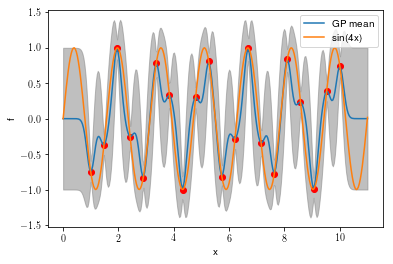

In [27]:
# The training points and training values
X = np.linspace ( 1 , 10 , 20 ).reshape(-1,1)
f = np.sin ( 4. * X )

# The test points and real values of f at test points
Xstar = np.linspace ( 0 , 11 , 300 ).reshape(-1,1)
fstar = np.sin ( 4. * Xstar )

# Choose a kernel, a nugget, and compute the covariance matrice
length_scale = 0.02
KXX = squared_exponential_kernel ( X , X , scale=length_scale , metric=None )
KXXstar = squared_exponential_kernel ( Xstar , X , scale=length_scale , metric=None )
nugget_val = 1e-2
nugget = np.diag ( nugget_val * np.ones ( X.shape[0] ) )

# Steps 1-2
L = LA.cholesky ( KXX + nugget )
alpha = LA.cho_solve ( (L.T,False) , LA.cho_solve((L,True), f) )

# Steps 3-5
fstar_bar = np.dot ( KXXstar , alpha )
variances = []
for i in range ( KXXstar.shape[0] ):
    v = LA.cho_solve ( (L,True) , KXXstar[i,:] )
    variances.append ( 1. - np.dot(v.T,v) )
stds = np.sqrt ( np.array ( variances ) )

# Step 6
lml = -(1./2.) * np.dot ( f.T , alpha ) - np.sum ( np.log ( np.diag(L) ) ) - (1./2.) * np.log ( 2*np.pi )
lml = lml.flatten()[0]
print('The log likelihood is',lml)

plt.plot ( X , f , 'ro' )
plt.plot ( Xstar , fstar_bar , label='GP mean' )
plt.plot ( Xstar , fstar , label='sin(4x)' )

Xstar, fstar_bar = Xstar.flatten ( ), fstar_bar.flatten ( )
plt.fill_between ( Xstar , fstar_bar-stds , fstar_bar + stds , alpha=0.5 , color='gray' )
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

## 4.2 Choosing the Kernel and Hyperparameters
The kernel and it's associated hyperparameters are the bedrock of the Gaussian process regression and determine the overall morphology of the interpolations.  In most cases of interpolating smooth functions, the squared-exponential will suffice, and in simple cases one can even hand tune the hyperparameters.  In the machine-learning context though, one is more interested in fitting the hyperparameters to maximize some objective function of the observed data.  The squared-exponential kernel may not be right for all cases, either, as we shall see.  

The most natural objective function for deciding on kernel and/or hyperparameter choice is the log marginal likelihood. Let's perform the same interpolation as above but choose hyperparameters that maximize this.  One can also optionally introduce a "hyperprior", ie. a prior distribution on hyperparameter values. This can be helpful if the marginal likelihood is not well behaved or has many local minima.

In [29]:
np.seterr(divide='raise',under='warn',over='raise')
def log_marginal_likelihood(theta,X,f):
    """
    Compute the log_marginal_likelihood of data f
    at points X under GP given by covariance K
    
    Parameters
    ----------
    theta: array
        array of hyperparameters
    X: array
        array of GP input points
    f: array
        array of data at X
    
    Returns
    -------
    lml: float
        log marginal likelihood of data f
    """
    if np.any(np.absolute(theta)> 3.):
        return -1e500
    cov_scale = 10.**theta[0]
    length_scale = 10.**theta[1]
    try:
        K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
        nugget = np.diag((10.**theta[2])*np.ones(X.shape[0]))
        #nugget = np.diag(nugget_val*np.ones(X.shape[0]))
        L = spl.cholesky(K+nugget,lower=True)
        alpha = spl.cho_solve((L.T,False),spl.cho_solve((L,True), f))
        lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
        lml = lml.flatten()[0]
    except:
        return -1e500
    return lml

from scipy.stats import norm
def log_hyperprior(theta,theta_means,theta_widths):
    """
    The log hyperprior
    
    Parameters
    ----------
    theta: array
        array of parameter values
    theta_means: array
        array of mean values of lognormal prior
    theta_widths:
        widths of lognormal prior
    
    Returns
    -------
    log_h: float
        log hyperprior
    """
    log_h = 0.
    for i in range(len(theta)):
        log_h = log_h + np.log(norm.pdf(theta[i], theta_means[i], theta_widths[i]))
    return log_h

def log_hyperposterior(theta,X,f,theta_means,theta_widths):
    """
    The log hyperposterior
    
    Parameters
    ----------
    theta: array
        array of hyperparameters
    X: array
        array of GP input points
    f: array
        array of data at X
    theta_means: array
        array of mean values of lognormal prior
    theta_widths:
        widths of lognormal prior
        
    Returns
    -------
    log_hyperposterior: float
        the log hyperposterior
    """
    return log_marginal_likelihood(theta,X,f)+log_hyperprior(theta,theta_means,theta_widths)

To begin with, we'll do a brute-force optimization by pulling a bunch of parameter values from the hyperprior and then checking the hyperposterior values to find the maximum.

In [31]:
# The training points and training values
X = np.linspace(1,10,30).reshape(-1,1)
f = np.sin(4.*X)

theta_means = [0.,-1.,-1]
theta_widths= [1.,1.,1.]
ntries = 500
loghps = []
thetas = []
for j in range(ntries):
    theta = [] 
    for i in range(len(theta_means)):
        theta.append(np.random.normal(theta_means[i], theta_widths[i]))
    loghps.append(log_hyperposterior(theta,X,f,theta_means,theta_widths))
    thetas.append(theta)
loghps=np.array(loghps)
thetas=np.array(thetas)

theta = thetas[np.argwhere(loghps==np.amax(loghps))][0][0]
print(theta)

/Users/christophermoore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: underflow encountered in exp
/Users/christophermoore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: underflow encountered in multiply


[-1.19072587 -1.33845045 -2.18730387]


/Users/christophermoore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: underflow encountered in exp
/Users/christophermoore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: underflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/christophermoore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: underflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


0.06445759959475945 0.045872198076747146 0.006496749652459937
The log likelihood is -1021.6333376171825


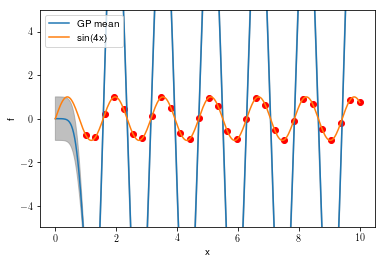

In [32]:

# The test points and real values of f at test points
Xstar = np.linspace(0,10,300).reshape(-1,1)
fstar = np.sin(4.*Xstar)

# Choose a kernel, nugget, and compute covariance matrices

cov_scale = 10.**theta[0]
length_scale = 10.**theta[1]
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)
nugget_val = 10**theta[2]
print(cov_scale,length_scale,nugget_val)
nugget = np.diag(nugget_val*np.ones(X.shape[0]))

# Steps 1-2
L = scipy.linalg.cholesky(KXX+nugget,lower=True)
alpha = scipy.linalg.cho_solve((L.T,False),scipy.linalg.cho_solve((L,True), f))

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = scipy.linalg.cho_solve((L,True),KXXstar[i,:])
    variances.append(1.-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print('The log likelihood is',lml)

plt.plot(X,f,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar,fstar_bar=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar,fstar_bar-stds,fstar_bar+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

If you want a look at the "hyperlikelihood", ie. the marginal likelihood as a function of the hyperparameters, you can use an mcmc:

In [37]:
nugget_val = 1e-5
ndim, nwalkers = 3, 20
#sampler = mc.EnsembleSampler(nwalkers, ndim, log_marginal_likelihood, args=(X, f))
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, args=(X, f,theta_means,theta_widths))
pos = [[-1.,-.1,-1.] + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 500);

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l$","$\log_{10}$ nugget"]);

/Users/christophermoore/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/christophermoore/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


# 5 Gaussian Process Regression: A More Sophisticated Gravitational Wave Example

I HAVE STARTED GATHERING THE NUMERICAL RELATIVITY DATA FOR THIS EXAMPLE, AND SOME PRELIMINARY CODE IS IN THE NOTEBOOK ./dev/SXS.ipynb.

# 6 Conclusions